# Feature extraction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,cohen_kappa_score, matthews_corrcoef
from scipy.stats import mode

Upload scaled data file obtained during the pre-processing step.  
Separate also variables dataframe (X) and response variable (y). Also is established a group according to "id" variable, representing each subject.

In [2]:
#Upload CSV file
scaled_data = pd.read_csv("Data/scaled_data.csv")

X = scaled_data.iloc[:, 1:754]  # Features
y = scaled_data.iloc[:, 754]    # Class
grup = scaled_data["id"]        # Grouped observations by id

To extract different features from the dataset, multiple methods will be applied. Each method will incorporate a cross-validation step to evaluate the performance of the extracted features. The number of extracted features will be based on the best metrics achieved during the cross-validation process.

For the cross-validation, a Random Forest classifier will be used and data will be split using Stratified Group K-Fold, which ensures that observations from the same subject are kept together within each fold. Additionally, the data splits will be balanced to account for class distribution.

Considering that each subject is represented by three different observations, a voting process will be applied to classify the subject into either the Parkinson's or healthy group. This process will aggregate the predictions from all three observations to determine the final classification for each subject. The majority vote from the individual observations will dictate the subject's group classification.

To achieve this, first will be defined a function for the cross-validation process. The metrics to be evaluated include accuracy, F1-score, kappa, and Matthews correlation coefficient (MCC).

In [3]:
def cv_rf(sel_features, y, grup, num_components):
    """
    Cross-validation with SGKF and Random forest
    """
    
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=123)
    rf = RandomForestClassifier(random_state=123, class_weight="balanced")
    
    pred_rf = []
    labels = []
    
    # Cross-validation
    for train_idx, test_idx in sgkf.split(sel_features, y, groups=grup):
        X_train, X_test = sel_features.iloc[train_idx], sel_features.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train model
        rf.fit(X_train, y_train)

        # Prediction
        rf_predictions = rf.predict(X_test)
        
        # Add prediction and labels
        pred_rf.extend(rf_predictions)
        labels.extend(y_test)
        
    # Predictons voting for each patient 
    final_pred_rf = []
    for i in range(0, len(labels), 3):  # 3 entrances for patient
        patient_preds = pred_rf[i:i+3]
        
        final_rf = mode(patient_preds).mode.item()
        final_pred_rf.append(final_rf)
     
    # Metrics calculation
    accuracy = accuracy_score(labels[::3], final_pred_rf)
    f1 = f1_score(labels[::3], final_pred_rf, average='weighted')
    kappa = cohen_kappa_score(labels[::3], final_pred_rf)
    mcc = matthews_corrcoef(labels[::3], final_pred_rf)
    
    
    # Results summary
    result = {
        'num_components': num_components,
        'accuracy': accuracy,
        'F1': f1,
        'Kappa': kappa,
        'MCC': mcc,
    }
    return result

In [4]:
def metric_plot(df):
    """ 
    Plot metrics obtained with cv_rf
    """
       
    # Plot grid
    fig, axs = plt.subplots(2,2, figsize = (10,8))
    fig.suptitle("Performance Metrics")
    
    #Accuracy plot
    axs[0,0].plot(df['num_components'], df['accuracy'], marker = 'o')
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_xlabel('Num. Components')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].grid(True)
    
    #F1 plot
    axs[0,1].plot(df['num_components'], df['F1'], marker = 'o')
    axs[0, 1].set_title('F1-score')
    axs[0, 1].set_xlabel('Num. Features')
    axs[0, 1].set_ylabel('F1-score')
    axs[0, 1].grid(True) 
    
    # Kappa
    axs[1,0].plot(df['num_components'], df['Kappa'], marker="o")
    axs[1,0].set_title('Kappa')
    axs[1,0].set_xlabel('Num. Components')
    axs[1,0].set_ylabel('Kappa')
    axs[1,0].grid(True) 
    
     # MCC
    axs[1,1].plot(df['num_components'], df['MCC'], marker='o')
    axs[1,1].set_title('MCC')
    axs[1,1].set_xlabel('Num. Components')
    axs[1,1].set_ylabel('MCC')
    axs[1,1].grid(True)    
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()   

## Principal Component Analysis (PCA)

Feature extraction is performed using Principal Component Analysis (PCA).   
Initially, a PCA with 100 components is evaluated to estimate the number of components required to achieve a satisfactory cumulative explained variance.   
Then, the optimal number of components is selected based on cross-validation metrics, ensuring an effective balance between dimensionality reduction and model performance.

In [5]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

In [6]:
#PCA Analysis with 100 components
pca_global = PCA(n_components = 100)
X_pca_global = pca_global.fit_transform(X) 

# Calculate explained variance
explained_variance_ratio = np.cumsum(pca_global.explained_variance_ratio_)
explained_variance_ratio0 = np.append(0, explained_variance_ratio)  

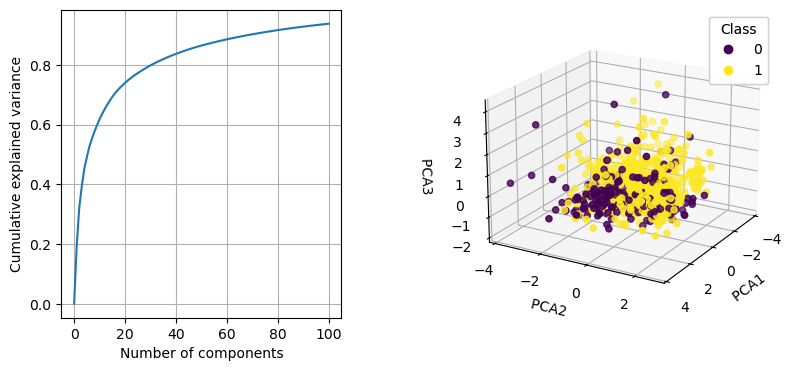

In [7]:
# Plot PCA results:
fig = plt.figure(figsize=(14, 4))
gs = GridSpec(1, 2, width_ratios=[1, 2]) 

# Figure cumulative variance
ax1 = fig.add_subplot(gs[0])
ax1.plot(explained_variance_ratio0)
ax1.grid()
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Cumulative explained variance')

# Plot according PCA1, PCA2 and PCA3
ax2 = fig.add_subplot(gs[1], projection='3d')
scatter = ax2.scatter(X_pca_global[:, 0], X_pca_global[:, 1],X_pca_global[:, 2], c=y)
ax2.set_xlabel('PCA1 ')
ax2.set_ylabel('PCA2 ')
ax2.set_zlabel('PCA3 ')
ax2.view_init(elev=20, azim=30) 

legend = ax2.legend(*scatter.legend_elements(), title="Class", loc='best')
ax2.add_artist(legend)

plt.subplots_adjust(left=0.1, right=0.7, wspace=0) 
plt.show()

### PCA with cross-validation

PCA is performed to optimize the number of components based on cross-validation metrics. The number of components evaluated ranges from 1 to 59, in increments of 2.

In [8]:
np.random.seed(123)
results_pca = []

#PCA Analysis
for num_comp in range(1,60,2):
    pca= PCA(n_components = num_comp, random_state=123)
    X_pca = pca.fit_transform(X) 
    
    # Cross-validation
    result = cv_rf(pd.DataFrame(X_pca), y, grup, num_components=num_comp)
    results_pca.append(result) 
    
results_pca_df = pd.DataFrame(results_pca)

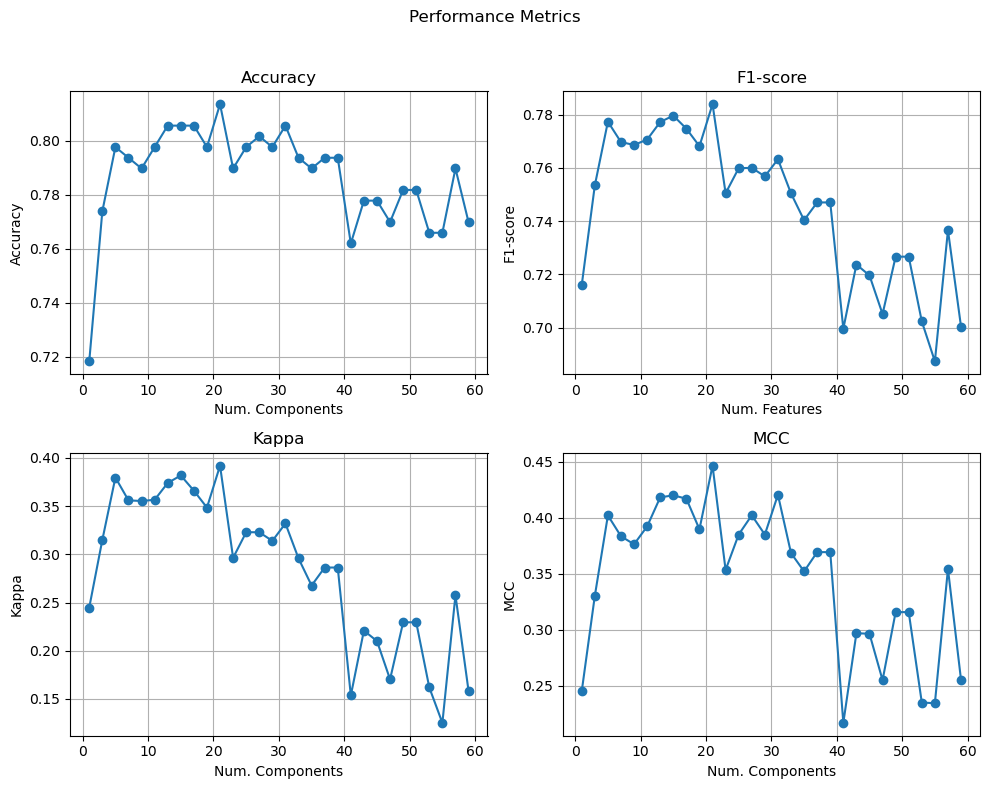

In [9]:
metric_plot(results_pca_df) 

Optimal number of components is determined to be 21. Compute PCA using 21 components and the resulting data is stored for further analysis.

In [10]:
#PCA Analysis: 15 components
np.random.seed(123)
for num_comp in range(21,22):
    pca= PCA(n_components = num_comp, random_state=123)
    X_pca = pca.fit_transform(X) 
    result_pca = cv_rf(pd.DataFrame(X_pca), y, grup, num_components=num_comp)
print(pd.DataFrame([result_pca]))

   num_components  accuracy       F1     Kappa       MCC
0              21  0.813492  0.78393  0.391867  0.446341


In [11]:
# Create dataframe with pca variables
pca_df = pd.DataFrame(X_pca)
pca_df.columns = [f'PCA{i+1}' for i in range(pca_df.shape[1])]  # Rename columns as PCA1, PCA2...

# Save feature extraction names of columns
pca_features= pca_df.columns.tolist()

## Multiple Factor Analysis (MFA)

Feature extraction is performed using Multiple Factor Analysis (MFA).

First, data needs to be grouped based on feature characteristics and reorganized for subsequent analysis using the  MFA function from the `prince` package.  

MFA is then performed with 100 components to estimate the number of components needed to achieve a satisfactory cumulative explained variance.   
Finally, the optimal number of components is chosen based on cross-validation metrics, ensuring an effective balance between dimensionality reduction and model performance.

In [12]:
import prince

# Data reorganization
groups = {  
    "Gender_Features" : scaled_data.columns[1:2].tolist(),
    "Baseline_Features": scaled_data.columns[2:23].tolist(),
    "Time_Freq_Features": scaled_data.columns[23:34].tolist(),
    "Vocal_Fold_Features": scaled_data.columns[34:56].tolist(),
    "MFCC_Features":  scaled_data.columns[56:140].tolist(),
    "WT_FT_Features": scaled_data.columns[140:322].tolist(),
    "TQWT_Features": scaled_data.columns[322:754].tolist()
}

# Create MultiIndex for groups of variables
arrays = []
for group, features in groups.items():
    arrays.append([(group, feature) for feature in features])

# Array of tupples
flattened_arrays = [item for sublist in arrays for item in sublist]

# Create new MultiIndex
multi_index = pd.MultiIndex.from_tuples(flattened_arrays, names=['Group', 'Feature'])

new_columns = [feature for features in groups.values() for feature in features]
scaled_data_multi = scaled_data[new_columns].copy()
scaled_data_multi.columns = multi_index

# Specify groups (subject id)
gr = scaled_data_multi.columns.levels[0].tolist()

In [13]:
# MFA analysis
num_components = 100

mfa = prince.MFA(
    n_components=num_components,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=123 )

mfa = mfa.fit(scaled_data_multi, groups=gr)
mfa_projected = mfa.transform(scaled_data_multi)

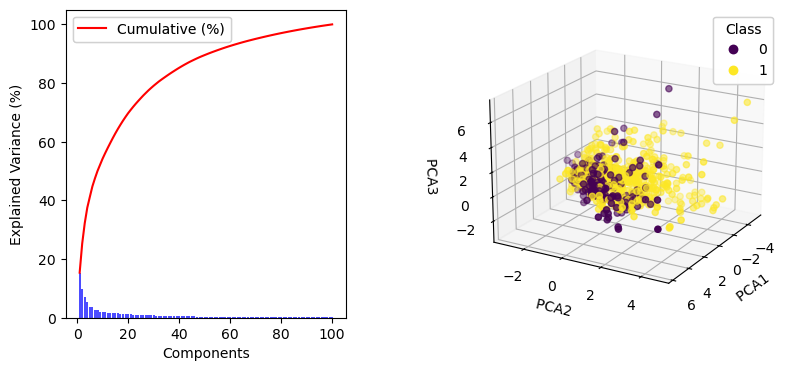

In [14]:
# Plot MFA results:
fig = plt.figure(figsize=(14, 4))
gs = GridSpec(1, 2, width_ratios=[1, 2]) 

# Figure eigenvalues
explained_variance_percentage = 100 * mfa.eigenvalues_ / np.sum(mfa.eigenvalues_)

ax1 = fig.add_subplot(gs[0])
ax1.bar(range(1, num_components + 1), explained_variance_percentage, color='b', alpha=0.7)
ax1.plot(range(1, num_components +1), np.cumsum(explained_variance_percentage),
        c='red',label='Cumulative (%)')
ax1.set_xlabel('Components')
ax1.set_ylabel('Explained Variance (%)')
ax1.add_artist(plt.legend(loc='best'))


# Plot according PCA1, PCA2 and PCA3
ax2 = fig.add_subplot(gs[1], projection='3d')
scatter = ax2.scatter(mfa_projected.iloc[:, 0], mfa_projected.iloc[:, 1],mfa_projected.iloc[:, 2], c=y)
ax2.set_xlabel('PCA1 ')
ax2.set_ylabel('PCA2 ')
ax2.set_zlabel('PCA3 ')
ax2.view_init(elev=20, azim=30) 

legend = ax2.legend(*scatter.legend_elements(), title="Class", loc='best')
ax2.add_artist(legend)


plt.subplots_adjust(left=0.1, right=0.7, wspace=0) 
plt.show()

### MFA with cross-validation

MFA is performed to optimize the number of components based on cross-validation metrics. The number of components evaluated ranges from 1 to 79, in increments of 2.

In [15]:
np.random.seed(123)
results_mfa = []

# MFA Analysis 
for n_components in range(1, 80, 2): 
    mfa = prince.MFA(
        n_components=n_components,
        n_iter=3,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=123
    )
    
    mfa = mfa.fit(scaled_data_multi, groups=gr)
    mfa_projected = mfa.transform(scaled_data_multi)
    
    # Cross-validation
    result = cv_rf(pd.DataFrame(mfa_projected), y, grup, num_components=n_components)
    results_mfa.append(result)

results_mfa_df = pd.DataFrame(results_mfa)  

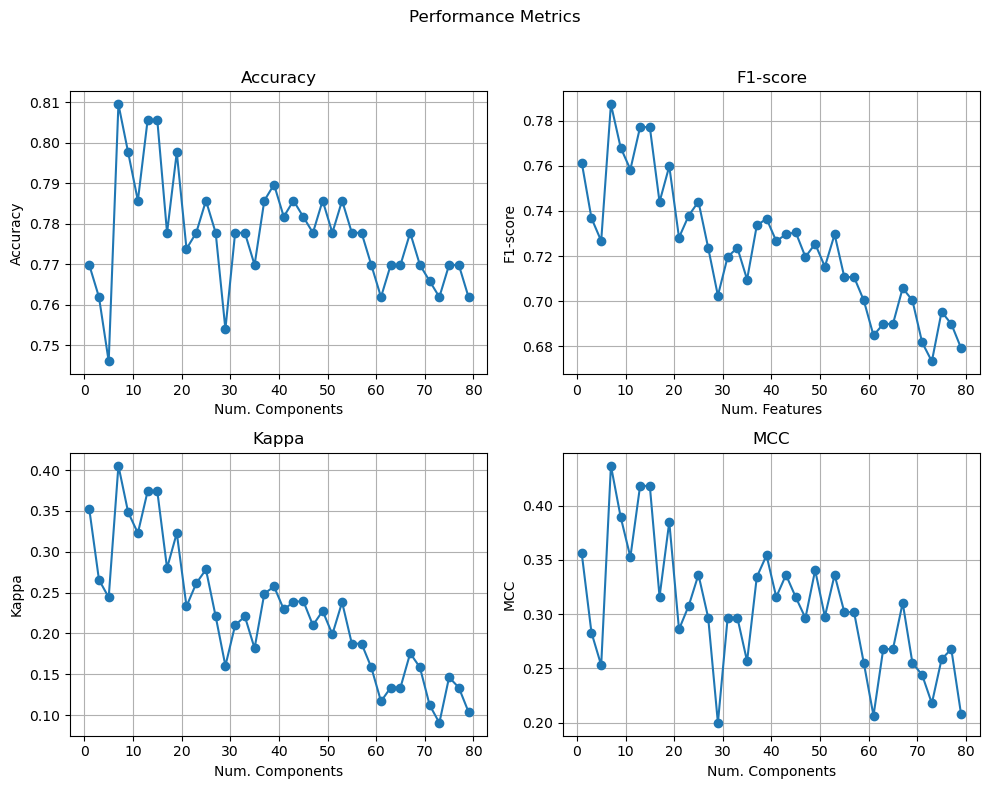

In [16]:
metric_plot(results_mfa_df) 

Optimal number of components is determined to be 7. Compute MFA using 7 components and the resulting data is stored for further analysis.

In [17]:
np.random.seed(123)

# MFA Analysis: 7 components
mfa = prince.MFA(
    n_components=7,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=123
    )
    
mfa = mfa.fit(scaled_data_multi, groups=gr)
mfa_projected = mfa.transform(scaled_data_multi)

# Cross-validation
result_mfa = cv_rf(pd.DataFrame(mfa_projected), y, grup, num_components=7)  

In [18]:
print(pd.DataFrame([result_mfa]))

   num_components  accuracy        F1     Kappa       MCC
0               7  0.809524  0.787407  0.405427  0.436699


In [19]:
# Create dataframe with mfa variables
mfa_df= pd.DataFrame(mfa_projected)
mfa_df.columns = [f'MFA{i+1}' for i in range(mfa_df.shape[1])]  # Rename columns as MFA1, MFA2...

# Save feature extraction names of columns
mfa_features= mfa_df.columns.tolist()

## t-Distributed Stochastic Neighbor Embeddingt (t-SNE )

Feature extraction is performed using t-SNE.

t-SNE is applied with a maximum of 3 components, as allowed by the method. Perplexity is tested across different values.  The optimal number of components and perplexity is chosen based on cross-validation metrics, ensuring a good model performance.

In [20]:
from sklearn.manifold import TSNE

In [21]:
np.random.seed(123)
results_tsne = []

for n_components in range(1, 4, 1):  
    for perplexity in range(1,50,2):
        # t-SNE
        tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=123)
        X_tsne = tsne.fit_transform(X)
        
        # Cross- validation
        result = cv_rf(pd.DataFrame(X_tsne), y, grup, num_components=n_components)
        result["Perplexity"] = perplexity
        results_tsne.append(result)
        
results_tsne_df = pd.DataFrame(results_tsne)         

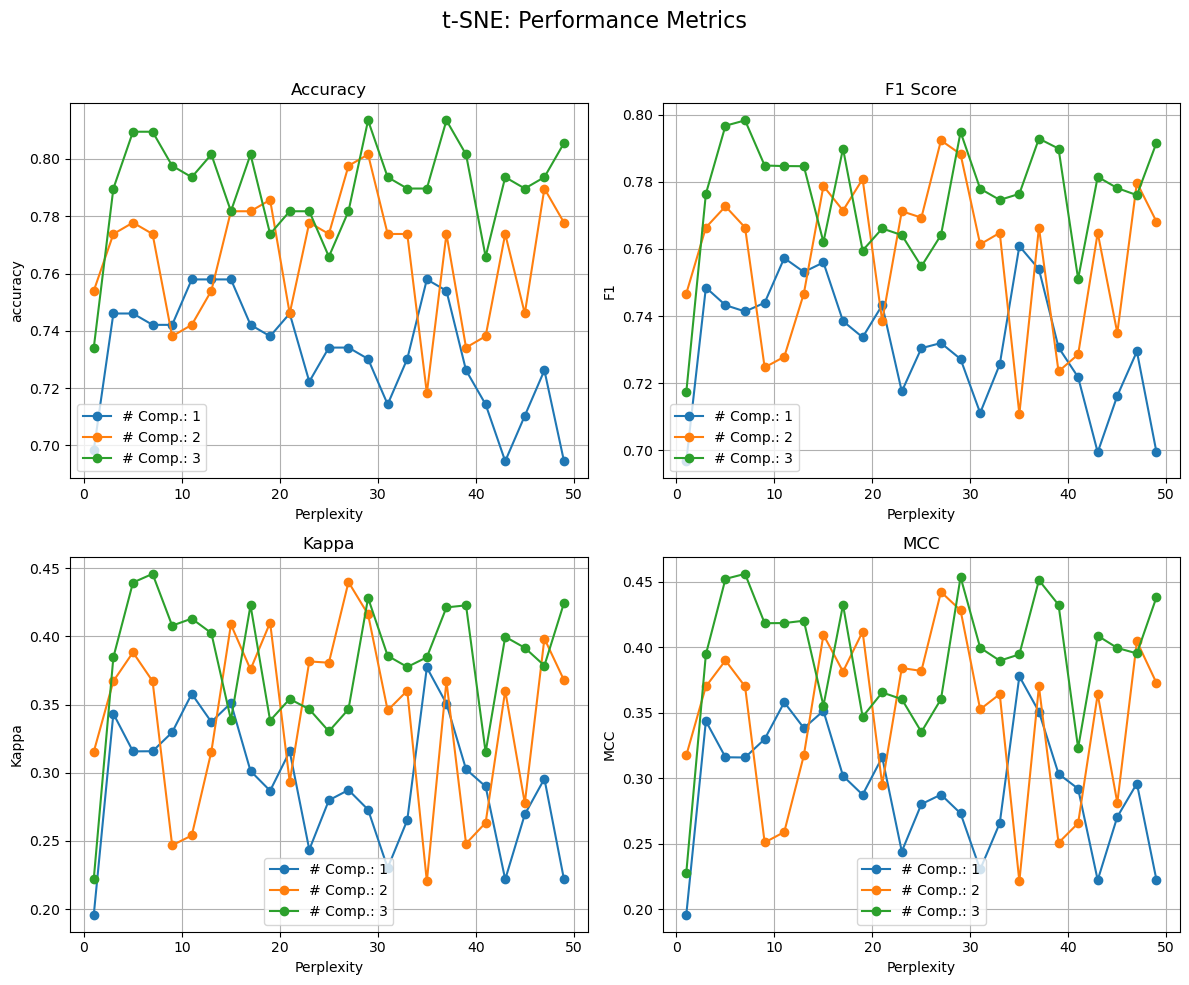

In [22]:
# Plot metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("t-SNE: Performance Metrics", fontsize=16)

metrics = ["accuracy", "F1", "Kappa", "MCC"]
titles = ["Accuracy", "F1 Score", "Kappa", "MCC"]
colors = sns.color_palette("husl", n_colors=results_tsne_df["num_components"].nunique())

# Crear cada subgràfic
for ax, metric, title in zip(axs.flat, metrics, titles):
    for num_comp in results_tsne_df["num_components"].unique():
        subset = results_tsne_df[results_tsne_df["num_components"] == num_comp]
        ax.plot(subset["Perplexity"], subset[metric], marker='o', label=f'# Comp.: {num_comp}')
    
    ax.set_title(title)
    ax.set_xlabel("Perplexity")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Optimal number of components is determined to be 3 and perplexity 7. Compute t-SNE using these parameters and the resulting data is stored for further analysis.

In [23]:
np.random.seed(123)

# t-SNE:components=3 and perplexity=7
tsne = TSNE(n_components=3, perplexity=7, random_state=123)
X_tsne = tsne.fit_transform(X)
    
# Cross-validation
result_tsne = cv_rf(pd.DataFrame(X_tsne), y, grup, num_components=3)  
result_tsne["Perplexity"] = 7
print(pd.DataFrame([result_tsne]))

   num_components  accuracy       F1     Kappa     MCC  Perplexity
0               3  0.809524  0.79829  0.445951  0.4559           7


In [24]:
# Create dataframe with t-SNE variables
tsne_df = pd.DataFrame(X_tsne)
tsne_df.columns = [f'tSNE{i+1}' for i in range(tsne_df.shape[1])]

# Save feature extraction names of columns
tsne_features = tsne_df.columns.tolist()

## Saving Extracted Features

The feature extraction results from the three employed methods are combined into a single, global dataframe. Each component will be labeled according to the respective feature extraction technique used and the number of component. The new data will then be saved into a new file for further analysis and future reference.

In [25]:
df_extracted_features = pd.concat([pca_df, mfa_df, tsne_df], axis=1)

# Save dataframe
df_extracted_features.to_csv('Data/df_extracted_features.csv', index=False)

In [26]:
# Create feature_extraction.py with the column name of the different components
with open("Data/feature_extraction.py", "w") as f:
    f.write(f'pca_features= {pca_features}\n')
    f.write(f'mfa_features={mfa_features}\n')
    f.write(f'tsne_features={tsne_features}\n')